Problem 1

In [99]:
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import skew, kurtosis
from scipy.stats import describe
import matplotlib.pyplot as plt
import scipy.linalg
import pprint as pprint
import time as time
from sklearn.decomposition import PCA


In [31]:
DailyReturns = pd.read_csv('DailyReturn.csv')


#insert label Date in first column
DailyReturns.insert(0, 'Date', DailyReturns.pop('Unnamed: 0'))
DailyReturns.head()

#index according to Date
DailyReturns.set_index('Date', inplace=True)
DailyReturns.head()

DailyReturns.index= pd.to_datetime(DailyReturns.index)
DailyReturns.head()

# #preprocess Daily Returns and normalize it
# DailyReturns = DailyReturns.dropna()
# DailyReturns = DailyReturns.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
# DailyReturns.head()






,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,FB,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-21,0.002608,0.001474,0.010897,0.005842,0.032571,0.000825,0.002566,0.003228,0.026648,-0.002330,...,-0.000329,-0.002156,-0.004130,0.010683,0.001944,0.005416,0.009789,0.012832,-0.004696,0.012841
2021-10-22,-0.001036,-0.005285,-0.005149,-0.028955,0.017539,-0.030443,-0.029104,-0.050515,0.001498,0.008437,...,0.015748,0.005984,-0.000207,-0.002181,0.003732,0.003913,-0.002568,-0.010957,0.013526,-0.008040
2021-10-25,0.005363,-0.000336,-0.003332,-0.004551,0.126616,-0.000869,0.001068,0.012569,0.019361,0.003527,...,0.002221,-0.002974,-0.005599,0.011770,0.006395,0.004618,-0.009720,-0.000173,0.002017,0.017145
2021-10-26,0.000900,0.004575,0.006426,0.016775,-0.006274,0.013543,0.006478,-0.039186,0.066952,0.002033,...,-0.002263,0.008121,0.003337,-0.003545,0.000887,-0.118035,0.000476,-0.006752,-0.002013,0.001073
2021-10-27,-0.004430,-0.003148,0.042114,0.004864,0.019078,0.049595,0.048367,-0.011368,-0.010762,-0.010555,...,-0.014625,-0.007233,-0.012679,-0.052368,-0.014174,-0.002922,-0.017132,-0.054210,-0.022191,-0.011786


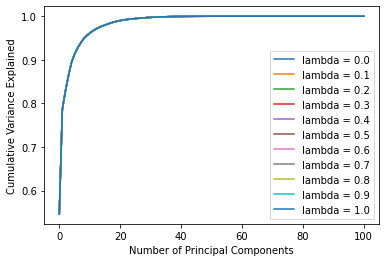

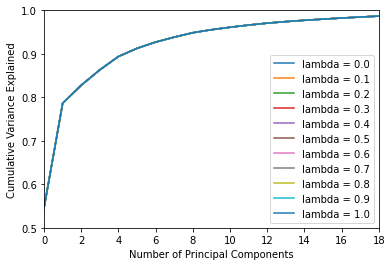

In [128]:

#Create exponentially_weighted_covariance _Matrix

def exponentially_weighted_covariance_matrix(DailyReturns, lam=0.94):
    n = DailyReturns.shape[0]
    weights = np.zeros(n)
    weights[n-1] = 1
    for i in range(n-2, -1, -1):
        weights[i] = lam * weights[i+1] + (1 - lam)
    weighted_returns = DailyReturns.multiply(weights, axis=0)
    cov_matrix = weighted_returns.cov()
    # cov_matrix = cov_matrix.to_numpy()
    return cov_matrix




lams = [ 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
cumulative_variances = []

for lam in lams:
    cov_matrix = exponentially_weighted_covariance_matrix(DailyReturns, lam)
    cov_matrix = cov_matrix.to_numpy()
    pca = PCA(n_components=None)
    pca.fit(cov_matrix)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    cumulative_variances.append(cumulative_variance)


plt.figure()
for i in range(len(lams)):
    plt.plot(cumulative_variances[i], label='lambda = {}'.format(lams[i]))
plt.legend(loc='best')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

plt.figure()
for i in range(len(lams)):
    plt.plot(cumulative_variances[i], label='lambda = {}'.format(lams[i]))
plt.legend(loc='best')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 18)
plt.ylim(0.5, 1.0)
plt.show()



# expWeightedCovMatrix = exponentially_weighted_covariance_matrix(DailyReturns,lam= .97)
# expWeightedCovMatrix.head()



# #convert expWeightedCovMatrix to a matrix from a pandas
# # expWeightedCovMatrix = expWeightedCovMatrix.to_numpy()
# # expWeightedCovMatrix

# pprint.pprint(expWeightedCovMatrix)




Problem 2

In [32]:
#Problem 2 Cholesky and nearPSD


def chol_psd(a):
    n = a.shape[0]
    root = np.zeros((n,n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j,0:j], root[j,0:j])
  
        temp = a[j,j] - s
        if temp < 0 and temp > -1e-8:
            temp = 0.0
        root[j,j] = np.sqrt(temp)

        if root[j,j] == 0.0:
            root[j+1:,j] = 0.0
        else:
            ir = 1.0 / root[j,j]
            for i in range(j+1, n):
                s = np.dot(root[i,0:j], root[j,0:j])
                root[i,j] = (a[i,j] - s) * ir 
    return root







In [34]:
n = 500
sigma = np.zeros((n, n))
sigma.fill(0.9)
for i in range(n):
    sigma[i, i] = 1.0
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

# cholesky_np= np.linalg.cholesky(sigma).T


In [129]:





n = 500
sigma_higham = np.zeros((n, n))
sigma_higham.fill(0.9)
for i in range(n):
    sigma_higham[i, i] = 1.0
sigma_higham[0, 1] = 0.7357
sigma_higham[1, 0] = 0.7357



#near_psd of sigma


# near_psd(sigma, epsilon=0.0)

#Highams 2002 nearest psd correlation function



def nearest_psd_correlation(A):
    """Compute the nearest positive semi-definite correlation matrix."""
    n = A.shape[0]
    eigvals, eigvecs = np.linalg.eig(A)
    d = np.diag(np.maximum(eigvals, 0))
    return eigvecs.dot(d).dot(eigvecs.T)

def higham_2002(A):
    """Higham's 2002 algorithm for finding the nearest PSD correlation matrix."""
    n = A.shape[0]
    X = (A + A.T) / 2
    X_old = np.zeros((n, n))
    while np.linalg.norm(X - X_old, ord='fro') > 1e-8:
        X_old = X.copy()
        X = nearest_psd_correlation(X)
    return X

#Highams 2002 nearest psd correlation function
sigma_higham = higham_2002(sigma_higham)
# chol_psd(root,processed_higham)



#print chol_psd


# #Cholesky decomposition of sigma
# chol_psd(processed_higham)

In [130]:
chol_psd(sigma_higham)

sigma_higham = chol_psd(sigma_higham)

print(sigma_higham)

C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


[[ 1.01572355  0.          0.         ...  0.          0.
   0.        ]
 [ 0.75551495  0.67888989  0.         ...  0.          0.
   0.        ]
 [ 0.8859426   0.33956888  0.09850978 ...  0.          0.
   0.        ]
 ...
 [ 0.8859426   0.33956888 -0.03435683 ...  0.          0.
   0.        ]
 [ 0.8859426   0.33956888  0.05142742 ...  0.          0.
   0.        ]
 [ 0.8859426   0.33956888  0.04511382 ...  0.          0.
   0.        ]]


In [131]:
#get eigenval
eigenval = np.linalg.eigvals(sigma)
print(eigenval)


[ 4.50099343e+02+0.00000000e+00j  2.64300000e-01+0.00000000e+00j
 -6.36430389e-02+0.00000000e+00j  1.00000000e-01+0.00000000e+00j
  1.00000000e-01+6.76018511e-15j  1.00000000e-01-6.76018511e-15j
  1.00000000e-01+7.74370922e-15j  1.00000000e-01-7.74370922e-15j
  1.00000000e-01+5.41661454e-15j  1.00000000e-01-5.41661454e-15j
  1.00000000e-01+2.07186123e-15j  1.00000000e-01-2.07186123e-15j
  1.00000000e-01+0.00000000e+00j  1.00000000e-01+3.05380713e-15j
  1.00000000e-01-3.05380713e-15j  1.00000000e-01+4.11744282e-15j
  1.00000000e-01-4.11744282e-15j  1.00000000e-01+0.00000000e+00j
  1.00000000e-01+5.72082977e-15j  1.00000000e-01-5.72082977e-15j
  1.00000000e-01+4.65879424e-15j  1.00000000e-01-4.65879424e-15j
  1.00000000e-01+4.08328997e-15j  1.00000000e-01-4.08328997e-15j
  1.00000000e-01+4.75325882e-15j  1.00000000e-01-4.75325882e-15j
  1.00000000e-01+0.00000000e+00j  1.00000000e-01+1.54249598e-15j
  1.00000000e-01-1.54249598e-15j  1.00000000e-01+4.20380161e-15j
  1.00000000e-01-4.203801

In [132]:
#Generate a non-PSD correlation matrix that is 500x500

n = 500
sigma_near = np.zeros((n, n))
sigma_near.fill(0.9)
for i in range(n):
    sigma_near[i, i] = 1.0
sigma_near[0, 1] = 0.7357
sigma_near[1, 0] = 0.7357



def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    invSD = None
    out = a.copy()

    if (np.diag(out) == 1).sum() != n:
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    vals, vecs = np.linalg.eig(out)
    vals = np.maximum(vals, epsilon)
    T = 1.0 / (vecs * vecs * vals).sum(axis=1)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T

    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD
    return out


In [133]:
sigma_near= near_psd(sigma_near, epsilon=0.0)

# print(near_psd_processed)

# chol_psd(near_psd_processed)

In [134]:
sigma_near= chol_psd(sigma_near)

print(sigma_near)


[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.74381947  0.66838058  0.         ...  0.          0.
   0.        ]
 [ 0.93066392  0.35670991  0.08137996 ...  0.          0.
   0.        ]
 ...
 [ 0.90554387  0.34708176 -0.03865452 ...  0.          0.
   0.        ]
 [ 0.90317328  0.34617315  0.05995525 ...  0.          0.
   0.        ]
 [ 0.87631502  0.33587877  0.08010347 ...  0.          0.
   0.        ]]


C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
C:\Users\Moneybag Mike\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


In [136]:
#Frobenius and calc time


def frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, ord='fro')

start = time.time()
highams = higham_2002(sigma)
end = time.time()
highams_time = end - start

start = time.time()
near_psd_matrix = near_psd(sigma)
end = time.time()
near_psd_time = end - start

print("Frobenius norm differential between sigma and Higham's corrected matrix:", frobenius_norm(sigma, highams))
print("Frobenius norm differential between sigma and near_PSD corrected matrix:", frobenius_norm(sigma, near_psd_matrix))
print("Time taken by Higham's method:", highams_time)
print("Time taken by near_PSD method:", near_psd_time)

Frobenius norm differential between sigma and Higham's corrected matrix: 10.601955731358144
Frobenius norm differential between sigma and near_PSD corrected matrix: 32.056372036273515
Time taken by Higham's method: 0.9053726196289062
Time taken by near_PSD method: 0.17799949645996094


Problem 3

In [17]:
#Problem 3
DailyReturns = pd.read_csv('DailyReturn.csv')


#insert label Date in first column
DailyReturns.insert(0, 'Date', DailyReturns.pop('Unnamed: 0'))
DailyReturns.head()

#index according to Date
DailyReturns.set_index('Date', inplace=True)
DailyReturns.head()

DailyReturns.index= pd.to_datetime(DailyReturns.index)
DailyReturns.head()


,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,FB,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-21,0.002608,0.001474,0.010897,0.005842,0.032571,0.000825,0.002566,0.003228,0.026648,-0.002330,...,-0.000329,-0.002156,-0.004130,0.010683,0.001944,0.005416,0.009789,0.012832,-0.004696,0.012841
2021-10-22,-0.001036,-0.005285,-0.005149,-0.028955,0.017539,-0.030443,-0.029104,-0.050515,0.001498,0.008437,...,0.015748,0.005984,-0.000207,-0.002181,0.003732,0.003913,-0.002568,-0.010957,0.013526,-0.008040
2021-10-25,0.005363,-0.000336,-0.003332,-0.004551,0.126616,-0.000869,0.001068,0.012569,0.019361,0.003527,...,0.002221,-0.002974,-0.005599,0.011770,0.006395,0.004618,-0.009720,-0.000173,0.002017,0.017145
2021-10-26,0.000900,0.004575,0.006426,0.016775,-0.006274,0.013543,0.006478,-0.039186,0.066952,0.002033,...,-0.002263,0.008121,0.003337,-0.003545,0.000887,-0.118035,0.000476,-0.006752,-0.002013,0.001073
2021-10-27,-0.004430,-0.003148,0.042114,0.004864,0.019078,0.049595,0.048367,-0.011368,-0.010762,-0.010555,...,-0.014625,-0.007233,-0.012679,-0.052368,-0.014174,-0.002922,-0.017132,-0.054210,-0.022191,-0.011786


In [144]:
def multivar_normal(mean, cov, size=1, pca=False, explained_variance=None):
    if pca:
        eigenval, eigenvect = np.linalg.eig(cov)
        idx = np.argsort(eigenval)[::-1]
        eigenval = eigenval[idx]
        eigenvect = eigenvect[:, idx]

        if explained_variance is not None:
            explained_variance = np.cumsum(eigenval) / np.sum(eigenval)
            n_components = np.searchsorted(explained_variance, explained_variance) + 1

            eigenval = eigenval[:n_components]
            eigenvect = eigenvect[:, :n_components]

        X = np.random.normal(size=(size, eigenvect.shape[0]))
        X = X @ np.diag(np.sqrt(eigenval)) @ eigenvect.T

        X = X + mean

        return X
    else:
        return np.random.multivariate_normal(mean, cov, size)

In [145]:
def simulate_multivar_normal(mean, cov, size=25000, pca=False, explained_variance=None, n=20):
    if pca:
        eigenval, eigenvect = np.linalg.eigh(cov)
        
        indices = np.argsort(-eigenval)
        eigenval = eigenval[indices]
        eigenvect = eigenvect[:, indices]
        
        eigenval = eigenval[:n]
        eigenvect = eigenvect[:, :n]
        
        X = np.random.normal(size=(size, eigenvect.shape[0]))
        X = X @ np.diag(np.sqrt(eigenval)) @ eigenvect.T
    else:
        X = np.random.multivariate_normal(mean, cov, size=size)
    
    X = X + mean
    
    return X

In [146]:
def generate_corr_matrix_and_var(DailyReturns, method='pearson', lam=0.97):
    if method == 'pearson':
        corr = np.corrcoef(DailyReturns, rowvar=False)

        var = np.var(DailyReturns, axis=0)

    elif method == 'exponentially_weighted':
        n = DailyReturns.shape[0]
        cov = np.zeros((DailyReturns.shape[1], DailyReturns.shape[1]))
        for i in range(n):
            cov = lam * cov + (1 - lam) * np.outer(DailyReturns[i], DailyReturns[i])

        var = np.diag(cov)

        stddev = np.sqrt(var)
        corr = cov / np.outer(stddev, stddev)

    return corr, var


In [147]:
corr, var = generate_corr_matrix_and_var(DailyReturns.values, method='pearson')
covar_pearson = np.diag(var) * corr
corr, var = generate_corr_matrix_and_var(DailyReturns.values, method='exponentially_weighted')
cov_exp_weighted = np.diag(var) * corr

mean = DailyReturns.mean().values
covs = [covar_pearson, cov_exp_weighted]
explained_variances = [None,0.5,0.75,1.0]

for cov in covs:
    for explained_variance in explained_variances:
        X = simulate_multivar_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=DailyReturns.shape[1])
        
        cov_sim = np.cov(X.T)
        
        print(f"Original covariance matrix:\n{cov}")
        print(f"Covariance of the simulated values:\n{cov_sim}")

Original covariance matrix:
[[7.71482917e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.53165588e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.50553256e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.17531002e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.96328665e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.72803673e-04]]
Covariance of the simulated values:
[[ 7.70149113e-05  3.46357227e-07  8.21667976e-07 ...  6.33388495e-07
  -4.27441401e-07 -1.40647891e-07]
 [ 3.46357227e-07  2.53206941e-04  1.08701724e-06 ...  3.10538993e-06
   1.02622352e-06  1.70472257e-06]
 [ 8.21667976e-07  1.08701724e-06  2.49208099e-04 ...  3.33540773e-06
  -5.34955253e-07 -2.40622552e-06]
 ...
 [ 6.33388495e-0

In [148]:
def compare_covariances(cov, cov_sim):
    return np.linalg.norm(cov - cov_sim)

frobenius_norms = []
for cov in covs:
    for explained_variance in explained_variances:
        X = simulate_multivar_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=DailyReturns.shape[1])
        cov_sim = np.cov(X.T)
        frobenius_norms.append(compare_covariances(cov, cov_sim))

print("Frobenius norms:", frobenius_norms)


Frobenius norms: [0.00021779229858067965, 0.0002136591592827028, 0.00021832686692913126, 0.00021783719496934394, 0.00018253277022931051, 0.00018080270076635115, 0.00018741291713272537, 0.0001778073200677663]


In [149]:
import time

run_times = []
for cov in covs:
    for explained_variance in explained_variances:
        start = time.time()
        X = simulate_multivar_normal(mean, cov, pca=explained_variance is not None, explained_variance=explained_variance, n=DailyReturns.shape[1])
        end = time.time()
        run_times.append(end - start)

print("Run times:", run_times)

Run times: [0.09599995613098145, 0.08600068092346191, 0.09059906005859375, 0.08762955665588379, 0.09300041198730469, 0.08617711067199707, 0.0840003490447998, 0.08199930191040039]
